# Predicting Amazon review score based only on the text

In this exercise I will use a Logistic regression model to explore if we can predict te score of a Book review in Amazon based exclusively on the text of the review.

I will begin importing the libraries necessary to perform this exercise.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient

import re

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

client = MongoClient()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ordovas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we load a fraction of the dataset and visualize the head of the dataset that we obtained.

In [45]:
db = client.get_database("amazon")
# Define an alias for the books dataset
books =db.books
# Obtain a random sample from the dataset, selecting only a few records 
# (we will use only overall and reviewTest, but I will load a few more just in case I
# want to play with more info...)
res = list(books.aggregate([
    { "$sample": { "size": 60000 }}
    ,{ "$project": {"id": "$_id", "_id": 0, "overall": 1, "reviewText": 1,"summary":1,"reviewerName":1}} 
]))
# Converting to pandas DataFrame
df=pd.DataFrame(res)

In [46]:
df.head()

,overall,reviewerName,reviewText,summary,id
0,5,High Speed,And marvel at the author's writing prowess,Makes you think and laugh,6033ab82f7ccad4a92f4c673
1,5,P. McDonald,very very good book,Five Stars,6033ab8af7ccad4a92f684bd
2,4,James Randall,"it was good, but The Given Day was better. Th...",live by night,6033ab97f7ccad4a92f90e4e
3,5,Ike E,It is a well constructed tale literally wise. ...,I did not find them complicated but very refre...,6033ab83f7ccad4a92f4e924
4,4,Lindsay,I really liked the way this book made me feel ...,Wonderful,6033ab80f7ccad4a92f46a3f


I wil now drop the NaN values for the `reviewText` column.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       60000 non-null  int64 
 1   reviewerName  59999 non-null  object
 2   reviewText    59994 non-null  object
 3   summary       59994 non-null  object
 4   id            60000 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


In [48]:
df=df.dropna(subset=['reviewText'])

Let's check that everything is fine...

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59994 entries, 0 to 59999
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   overall       59994 non-null  int64 
 1   reviewerName  59993 non-null  object
 2   reviewText    59994 non-null  object
 3   summary       59988 non-null  object
 4   id            59994 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.7+ MB


OK, so now I will examine the `overall` column, that is the target feature.

There are far more reviews with high score than with low score, so there is no balance. To solve this, later on I will weight the clases instead of select now the exact number of reviews for each score.

In [50]:
df["overall"].value_counts()

5    37735
4    12202
3     5553
2     2401
1     2103
Name: overall, dtype: int64

## Preprocessing: TF-IDF

I will create TF-IFD vectors for each review. TF-IDF meassures the frequency of each word inside a review and compares it with the number of documents where this word appears. 

To begin with I will clean the review text ignoring stop words and words with less than 4 letters, as they will likely not contain much information.

In [51]:
def cleaning_review(texts):
    #Remove numbers, punctuation and lowercase everything
    res=re.sub("[^A-Za-z]+", " ", texts.lower()) 
    #Remove words with less than 4 letters
    res=re.sub(r'\b\w{1,3}\b', "", res) 
    #Remove rest of stop words
    for stopword in stopwords.words('english'): 
        sw=stopword.replace("'","")
        res=res.replace(f" {sw} "," ")
    return res



Now I will create a feature with the "cleaned" text named `review_clean`

In [52]:
df["review_clean"]=df["reviewText"]
df["review_clean"]=df["review_clean"].apply(cleaning_review)
df=df.reset_index()

And then we can now create the TF-IDF vectors for each review using `TfidfVectorizer` from  `sklearn`.

In [53]:
v = TfidfVectorizer(min_df=5)
x = v.fit_transform(df['review_clean']).toarray()
df_tfidf = pd.DataFrame(x, columns=v.get_feature_names())

Just for curiosity, let's check how many features/words the TF-IDF vectors have...

In [54]:
len(v.get_feature_names())

22616

## Logistic Regression: Predicting the calification based on the TF-IDF vectors

First of all, we need to split the dataset into train and test samples. I will choose 85% of the sample to train and 15% to test.

The TD-IFD vectors are the features used to predict the target, that is the `overall` column that stores the calification.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(df_tfidf, df["overall"], test_size=0.15, random_state=42)

In [59]:
len(y_train),len(y_test)

(50994, 9000)

Now it's time to use the Logistic Regression model to predict the scores of the reviews.

We will activate `class_weight="balanced"`, as the classes (scores) are not balanced, so if we do not weight the classes the fit will be biased towards high scores (most populated classes).

This is just a very simple approach, without fine tuning anything and without checking overfitting. This is just an exercise for learning pruposes.

In [60]:
clf = LogisticRegression(random_state=0,class_weight="balanced").fit(X_train, y_train)

/home/ordovas/anaconda3/envs/ironhack/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


That's it? Well, now we need to check the performance of this model...

Let's check the score of the classification model for tha train and test samples

In [63]:
sc_train=clf.score(X_train, y_train)
sc_test=clf.score(X_test, y_test)
print(f"Train sample classification score: {round(sc_train,2)}")
print(f"Test sample classification score: {round(sc_test,2)}")

Train sample classification score: 0.7
Test sample classification score: 0.57


This seems just OK, but let's check an histogram to see the accuracy of the predictions by ploting the true score minus the predicted score.

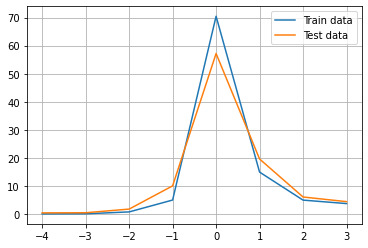

In [64]:
counts, bins = np.histogram(y_train-clf.predict(X_train),bins=np.arange(-4,5))
plt.plot(bins[:-1],counts*100/sum(counts),label="Train data")
plt.grid()
counts, bins = np.histogram(y_test-clf.predict(X_test),bins=np.arange(-4,5))
plt.plot(bins[:-1],counts*100/sum(counts),label="Test data")
plt.legend();

Well, this simple model seems not to be very wrong! Let's quantify this with the confusion matrices as well.

In [21]:
confusion_matrix(y_train,clf.predict(X_train))

array([[ 1668,    58,    22,    15,    31],
       [   78,  1878,    70,    36,    36],
       [  207,   328,  3259,   440,   354],
       [  291,   438,  1332,  6239,  2113],
       [  873,   788,  1787,  5803, 22836]])

In [22]:
confusion_matrix(y_test,clf.predict(X_test))

array([[ 167,   76,   38,   26,   23],
       [  80,  112,   71,   27,   27],
       [  75,  134,  262,  180,  101],
       [  66,   90,  318,  775,  560],
       [ 171,  160,  322, 1183, 3953]])

And normalized to the true scores.

Train subsample:


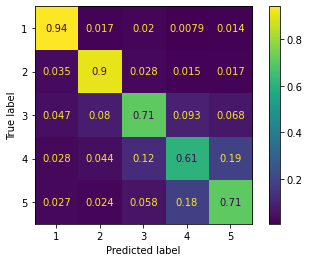

Test subsample:


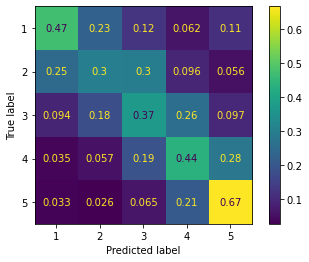

In [66]:
print("Train subsample:")
plot_confusion_matrix(clf, X_train, y_train,cmap="viridis",normalize="true") 
plt.show();
print("Test subsample:")
plot_confusion_matrix(clf, X_test, y_test,cmap="viridis",normalize="true")
plt.show();

The diagonal indicates that the Logistic Model predicts reasonably well the score of the review for this simple approach.

## Undersanding the Logistic Regression: How it is pedicted

I will create a DataFrame with the coefficients of each score to understand how the features (words) contributes to each class.

In [69]:
model=pd.DataFrame(clf.coef_,columns=X_train.columns)
model=model.T
model.columns=["1","2","3","4","5"]
model.head(20)

,1,2,3,4,5
aaron,-0.049567,-0.071994,0.039721,0.072350,0.009489
aback,-0.134650,0.137580,0.000253,0.049157,-0.052339
abandon,0.266166,-0.017877,0.030972,-0.208538,-0.070723
abandoned,0.251853,1.101523,-0.638317,-0.258630,-0.456429
abandoning,-0.245807,1.026284,-0.284890,-0.251009,-0.244578
abandonment,0.280877,-0.227939,0.109888,-0.143861,-0.018964
abandons,-0.257906,0.718769,-0.278523,-0.067920,-0.114419
abarat,0.130806,0.001331,0.004394,-0.330335,0.193804
abbey,-0.483536,-0.092659,0.468448,-0.141229,0.248976
abbott,-0.110253,-0.076059,0.385736,-0.149860,-0.049564


For the highest score, the words that are directly correlated and contributes the most are words as "excelent", "great", "love", "fantastic", "amazing"...

In [26]:
model["5"].sort_values(ascending=False).head(20)

highly         4.484097
excellent      4.045599
great          3.890946
wonderful      3.780433
amazing        3.629508
love           3.490875
perfect        3.456370
fantastic      3.309573
loved          3.117156
awesome        3.047435
beautiful      2.958332
brilliant      2.842893
thank          2.798243
beautifully    2.702918
loves          2.561907
wait           2.557949
incredible     2.415949
keeps          2.332581
wonderfully    2.314362
masterpiece    2.294892
Name: 5, dtype: float64

So, for the lowest score, it is not strange that the words that are directly correlated and contributes the most are words as "terrible","trash" or "awful".

In [27]:
model["1"].sort_values(ascending=False).head(20)

waste         6.505779
worst         4.742713
terrible      4.582867
awful         4.055568
trash         3.779797
money         3.661456
boring        3.632212
horrible      3.625463
even          3.512811
wasted        3.429691
bother        3.323911
garbage       3.320470
rubbish       3.314021
stupid        3.304465
ridiculous    3.282121
terribly      3.251973
refund        3.171680
poorly        3.124993
lame          3.123927
returned      3.079353
Name: 1, dtype: float64

With respect to the intermediate scores, the words that define these reviews are related to texts that show good and bad aspects of the porduct, so words like "however","though","unfortunately" are weighted high, as well as "okay","average" and "mediocre"

In [28]:
model["3"].sort_values(ascending=False).head(20)

okay             3.527615
however          2.963216
mediocre         2.787796
seemed           2.475055
still            2.421945
somewhat         2.419723
lacking          2.240698
alright          2.233896
felt             2.220561
though           2.219002
average          2.123789
unfortunately    2.099501
result           2.076707
kinda            2.048846
similar          2.046262
standards        2.033071
kind             2.029766
tends            1.941339
teens            1.919732
decent           1.919678
Name: 3, dtype: float64

On the other side, words with the lowest value of the coeficients show other information: features that are least likely to appear on a review. For instance, for the best reviewed books, we will not find words as "boring" or "disappointment".

In [29]:
model["5"].sort_values(ascending=True).head(20)

disappointing    -4.194741
boring           -4.172399
instead          -3.525276
however          -3.418187
unfortunately    -3.312846
worst            -3.255500
slow             -3.237849
tedious          -3.198042
depressing       -3.123319
waste            -3.081229
seemed           -3.050590
okay             -2.819607
predictable      -2.785566
problem          -2.763692
disappointment   -2.718056
seems            -2.687579
ridiculous       -2.682807
maybe            -2.554073
annoying         -2.521151
nothing          -2.495095
Name: 5, dtype: float64

For the products with lowest score, we will not find "excelent", "amazing", "interesting" or "great".

In [30]:
model["1"].sort_values(ascending=True).head(20)

excellent     -3.965991
great         -3.885040
well          -3.488946
stars         -3.384476
best          -3.384062
though        -3.343120
fascinating   -3.322394
enjoyed       -3.147007
usual         -3.103360
perfect       -3.100816
easy          -3.060450
turner        -2.951096
fairly        -2.826704
almost        -2.684947
eyes          -2.654855
rachel        -2.654685
amazing       -2.620896
interesting   -2.578624
love          -2.555968
highly        -2.534511
Name: 1, dtype: float64

Lastly, for scores as 3, we wll not find words that indicate extreme (good or bad) reviews. So features like "wonderful" and "wasted" have low weights.

In [31]:
model["3"].sort_values(ascending=True).head(20)

even         -3.278575
wasted       -2.345926
highly       -2.131530
wonderful    -2.054196
absolutely   -1.980176
adventure    -1.923176
recommend    -1.922932
large        -1.914421
complaint    -1.907569
ever         -1.899230
wait         -1.888203
amazon       -1.834478
loving       -1.820636
deeply       -1.813664
brings       -1.810703
important    -1.753685
children     -1.750991
extra        -1.737914
quit         -1.734294
couldn       -1.660330
Name: 3, dtype: float64

## Caveats

This is a very simple approach to understand this exercise, so we can inprove it a lot. We can reduce the dimensionality of the features using PCA, test different algorithms and tune the ML parameters. But in this notebook I show this simple solution to learn how it works.